<a href="https://colab.research.google.com/github/rufous86/spark_vs_pandas/blob/main/spark_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pyspark. Анализ больших данных, когда Pandas не достаточно

Pandas - одна из наиболее используемых библиотек Python с открытым исходным кодом для работы со структурированными табличными данными для анализа. Библиотека Pandas активно используется для аналитики данных, машинного обучения, проектов в области науки о данных и многих других.

Однако он не поддерживает распределенную обработку, поэтому вам всегда придется увеличивать ресурсы, когда вам понадобится дополнительная мощность для поддержки растущих данных.

Проще говоря, Pandas выполняет операции на одной машине, в то время как PySpark работает на нескольких машинах. Если вы работаете над приложением машинного обучения, где вы имеете дело с большими наборами данных, PySpark является лучшим вариантом, который может обрабатывать операции во много раз (100x) быстрее, чем Pandas.

PySpark - это библиотека Spark, написанная на языке Python для запуска приложений Python с использованием возможностей Apache Spark. Используя PySpark, мы можем запускать приложения параллельно на распределенном кластере (несколько узлов) или даже на одном узле.

Скачаем необходимые наборы данных с kaggle  
инструкция по скачиванию данных в colab напрямую с kaggle ниже:  
https://www.kaggle.com/general/74235

![](https://github.com/rufous86/spark_vs_pandas/blob/main/assets/kaggle_token.png?raw=1)

In [ ]:
# ! pip install -q kaggle
# from google.colab import drive
# drive.mount('/content/drive')
# ! mkdir ~/.kaggle
# ! cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c 'riiid-test-answer-prediction'
# ! mkdir data
# ! unzip riiid-test-answer-prediction.zip -d data

In [ ]:
# ! pip install pyspark
# ! pip install pyarrow

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark

22/12/15 07:21:34 WARN Utils: Your hostname, andrei-MacBookPro resolves to a loopback address: 127.0.1.1; using 192.168.0.6 instead (on interface wlp2s0)
22/12/15 07:21:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/15 07:21:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

In [ ]:
df = spark.read.csv('data/train.csv', header=True, inferSchema=True)

In [ ]:
df.printSchema()

root
 |-- row_id: integer (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- content_id: integer (nullable = true)
 |-- content_type_id: integer (nullable = true)
 |-- task_container_id: integer (nullable = true)
 |-- user_answer: integer (nullable = true)
 |-- answered_correctly: integer (nullable = true)
 |-- prior_question_elapsed_time: double (nullable = true)
 |-- prior_question_had_explanation: boolean (nullable = true)



In [ ]:
df.show()

+------+---------+-------+----------+---------------+-----------------+-----------+------------------+---------------------------+------------------------------+
|row_id|timestamp|user_id|content_id|content_type_id|task_container_id|user_answer|answered_correctly|prior_question_elapsed_time|prior_question_had_explanation|
+------+---------+-------+----------+---------------+-----------------+-----------+------------------+---------------------------+------------------------------+
|     0|        0|    115|      5692|              0|                1|          3|                 1|                       null|                          null|
|     1|    56943|    115|      5716|              0|                2|          2|                 1|                    37000.0|                         false|
|     2|   118363|    115|       128|              0|                0|          0|                 1|                    55000.0|                         false|
|     3|   131167|    115|  

In [ ]:
from pyspark.sql.types import IntegerType

df = df.withColumn('prior_question_had_explanation', df['prior_question_had_explanation'].cast(IntegerType()))
df.show()
df.printSchema()

+------+---------+-------+----------+---------------+-----------------+-----------+------------------+---------------------------+------------------------------+
|row_id|timestamp|user_id|content_id|content_type_id|task_container_id|user_answer|answered_correctly|prior_question_elapsed_time|prior_question_had_explanation|
+------+---------+-------+----------+---------------+-----------------+-----------+------------------+---------------------------+------------------------------+
|     0|        0|    115|      5692|              0|                1|          3|                 1|                       null|                          null|
|     1|    56943|    115|      5716|              0|                2|          2|                 1|                    37000.0|                             0|
|     2|   118363|    115|       128|              0|                0|          0|                 1|                    55000.0|                             0|
|     3|   131167|    115|  

In [ ]:
df.pandas_api().isna().sum()

row_id                                  0
timestamp                               0
user_id                                 0
content_id                              0
content_type_id                         0
task_container_id                       0
user_answer                             0
answered_correctly                      0
prior_question_elapsed_time       2351538
prior_question_had_explanation     392506
dtype: int64

Посмотрим, сколько в нашей таблице пустых значений

In [ ]:
df = df.dropna()
df.pandas_api().isna().sum()

row_id                            0
timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
dtype: int64

Проанализируем характеристики, влияющие на успеваемость студентов. Так как фактически данные об успеваемости у нас отсутствуют, условно за успеваемость будут выступать правильно данные ответы.      
Сначала сохраним колонку answered_correctly в переменную target. Это будет наша целевая переменная  
Затем рассчитаем коэффициент корреляции целевой переменной с каждой из остальных характеристик

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [ ]:
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

In [ ]:
import pandas as pd

corr_matrix_df = pd.DataFrame(data=cor_np, columns = df.columns, index=df.columns)

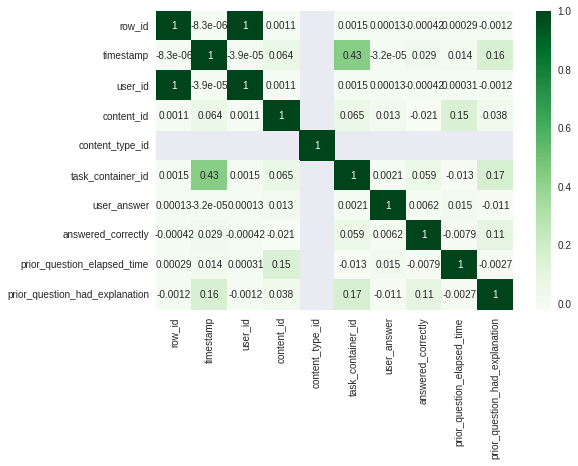

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plt.figure(figsize=(16,5))  
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)
plt.show()